In [432]:
import sympy as sp
import numpy as np
from IPython.display import display, Math
from sympy import pprint,simplify, expand, sstr, latex
from matplotlib import pyplot as plt


# Define symbolic variables
m, psi_n1, psi_n1_bar, psi_n2, psi_n2_bar, psi_n3, psi_n3_bar, t, a, b = sp.symbols('m psi_n1 psi_n1_bar psi_n2 psi_n2_bar psi_n3 psi_n3_bar t a b')
m, t, a, b, eta, alpha = sp.symbols('m t a b η α', real=True)
eps=sp.Symbol('ε', real=True)
R=sp.Rational

In [724]:
a=50 # omega
b=50 # omega^'
eps=1
alpha=0.905
beta=0.45
eta=0.306
bx=48
c=0.45


In [725]:


sp.sin(alpha).evalf()

0.786425154952674

In [726]:




H_44 = sp.Matrix([[a*sp.cos(alpha).evalf(), a*sp.sin(alpha).evalf(), eta, eps],
               [a*sp.sin(alpha).evalf(), -a*sp.cos(alpha).evalf(), eps, eta],
               [eta, eps, c-b*sp.cos(beta).evalf(), b*sp.sin(beta).evalf()],
               [eps, eta, b*sp.sin(beta).evalf(), c+b*sp.cos(beta).evalf()]])

In [727]:
H_44

Matrix([
[30.8842789966701,  39.3212577476337,             0.306,                1],
[39.3212577476337, -30.8842789966701,                 1,            0.306],
[           0.306,                 1, -44.5723551176338, 21.7482767055615],
[               1,             0.306,  21.7482767055615, 45.4723551176338]])

In [728]:
#finding eigenvectors and eigenvalues

In [729]:
import sympy as sp

I = sp.I

def hermitian_inner(u: sp.Matrix, v: sp.Matrix):
    """Hermitian inner product <u,v> = u^† v (returns a scalar)."""
    return (u.conjugate().T * v)[0]

def hermitian_gs(vectors, tol_simplify=True):
    """
    Hermitian Gram–Schmidt orthonormalization.
    Input: list of column vectors (sympy Matrix of shape (n,1))
    Output: list of orthonormal column vectors
    """
    ortho = []
    for v in vectors:
        w = sp.Matrix(v)  # copy
        for q in ortho:
            w = w - hermitian_inner(q, w) * q
        norm2 = sp.simplify(hermitian_inner(w, w)) if tol_simplify else hermitian_inner(w, w)
        # If symbolic, norm2 might not simplify to 0 even when it is; this is a best-effort check:
        if norm2 == 0:
            continue
        w = w / sp.sqrt(norm2)
        w = sp.simplify(w) if tol_simplify else w
        ortho.append(w)
    return ortho

def unitary_diagonalizer(H: sp.Matrix):
    """
    For Hermitian H, returns (U, D) where:
      - U is unitary (U.H*U = I)
      - D is diagonal (U.H*H*U = D) with eigenvalues on diagonal
    """
    n = H.shape[0]
    if H.shape[0] != H.shape[1]:
        raise ValueError("H must be square.")

    # (Optional) sanity check: Hermitian
    if sp.simplify(H - H.H) != sp.zeros(n):
        print("Warning: H does not simplify to Hermitian (H != H.H). Proceeding anyway.")

    eigs = H.eigenvects()  # [(eigenvalue, multiplicity, [basis vectors]), ...]

    # Build an orthonormal basis by orthonormalizing each eigenspace separately.
    # This avoids mixing eigenvectors from different eigenvalues (important for correctness).
    columns = []
    diag_entries = []

    for lam, mult, basis in eigs:
        # Ensure each basis vector is a column vector
        basis_cols = []
        for v in basis:
            v = sp.Matrix(v)
            if v.shape == (n,):        # row-ish
                v = v.reshape(n, 1)
            elif v.shape == (1, n):    # row vector
                v = v.T
            basis_cols.append(v)

        # Orthonormalize within this eigenspace
        onb = hermitian_gs(basis_cols)

        # Some eigenvects() bases may be smaller than multiplicity if symbolic issues occur;
        # we just take what we got.
        for q in onb:
            columns.append(q)
            diag_entries.append(lam)

    # Stack columns into U
    if len(columns) != n:
        raise ValueError(
            f"Did not obtain a full eigenbasis (got {len(columns)} vectors, expected {n}). "
            "This can happen with symbolic parameters; consider substituting numeric values or using .eigenvects() differently."
        )

    U = sp.Matrix.hstack(*columns)

    # Diagonal matrix of eigenvalues in the same column order
    D = sp.diag(*diag_entries)

    # Optional: enforce simplification
    U = sp.simplify(U)
    D = sp.simplify(D)

    return U, D

In [730]:
U, D = unitary_diagonalizer(H_44)

In [731]:
display(Math(r"U = " + latex(U) + r",\quad D = " + latex(D)   ))

<IPython.core.display.Math object>

In [732]:
sp.nsimplify(D)

Matrix([
[-50.5899038970297,                 0,                0,                0],
[                0, -48.9622604340977,                0,                0],
[                0,                 0, 49.0387402878887,                0],
[                0,                 0,                0, 51.4134240432388]])

In [733]:
#finding Se^(-iH_Dt)S.H

In [734]:
np.sqrt(65)*6

48.373546489791295

In [735]:
H_D=D
S_diag_44=sp.simplify(U*sp.exp(-I*H_D*t)*U.H)

In [736]:
k=4
P_44=sp.zeros(4,4)
for i in range(k):
    for j in range (k):
        P_44[i,j]=sp.simplify(sp.expand_complex(S_diag_44[i,j]*S_diag_44[i,j].conjugate().rewrite(sp.sin)))
sp.simplify(sp.expand_complex(S_diag_44[0,0]*S_diag_44[0,0].conjugate()))
P_44

Matrix([
[                                                                                                                                                                                                                                                  0.0170750161624733*cos(1.6276434629321*t) + 0.315429147968006*cos(2.3746837553502*t) + 3.46944695195361e-18*cos(2.4511636091411*t) + 5.47182347987462e-19*cos(97.9245208681954*t) + 0.0683227906393278*cos(98.0010007219863*t) + 0.1155040890527*cos(99.6286441849184*t) + 0.0466300184161575*cos(100.375684477336*t) + 0.0788310569470303*cos(102.003327940269*t) + 8.75491756779939e-18*cos(102.826848086478*t) + 0.358207880814306, -3.23387732267177e-18*sin(48.9622604340977*t)**2 + 0.0672440994188265*sin(48.9622604340977*t)*sin(49.0387402878886*t) + 0.0459240942387401*sin(48.9622604340977*t)*sin(51.4134240432388*t) - 6.46775464534355e-18*sin(49.0387402878886*t)**2 + 0.116512709642772*sin(49.0387402878886*t)*sin(50.5899038970298*t) + 0.0717553431394263

In [737]:
def cos_to_sin2_halfangle(expr: sp.Expr) -> sp.Expr:
    """Replace cos(u) -> 1 - 2*sin(u/2)**2 everywhere (no phase shift)."""
    u = sp.Wild('u')
    out = expr.replace(sp.cos(u), 1 - 2*sp.sin(u/2)**2)
    expr = str(sp.expand(out))
    return (expr
    )

In [738]:
p_44_sin = P_44.applyfunc(cos_to_sin2_halfangle)

# example: expand in eps up to eps^5 (order=6)
#t, eps = sp.symbols('t eps', real=True)

#p_6_sin_series = p_6_sin.applyfunc(lambda e: sp.series(e, eps, 0, 6).removeO().expand())

# display each entry with indices
for i in range(k):
    for j in range(k):
        display(Math(rf"P44_{{{i}{j}}}=" + sp.latex(p_44_sin[i, j])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [739]:
s=P_44[0,0]+P_44[0,1]+P_44[0,2]+P_44[0,3]


In [740]:
P_12=P_44[0,0]+P_44[0,1]
P_34=P_44[0,2]+P_44[0,3]

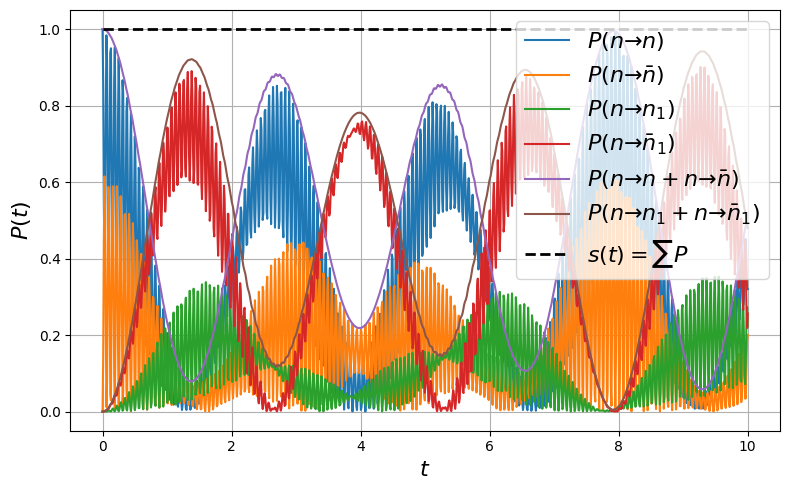

In [741]:
params = {
    m: 1.0
}
P_dict = {
    r"$P(n\to n)$": P_44[0,0],
    r"$P(n\to \bar n)$": P_44[0,1],
    r"$P(n\to n_1)$": P_44[0,2],
    r"$P(n \to \bar n_1)$": P_44[0,3],
    r"$P(n \to n+ n\to \bar n)$": P_12,
    r"$P(n \to n_1+ n\to \bar n_1)$": P_34,
}
P_funcs = {
    label: sp.lambdify(t, expr.subs(params), "numpy")
    for label, expr in P_dict.items()
}
t_vals = np.linspace(0, 10, 1000)
plt.figure(figsize=(8,5))

for label, f in P_funcs.items():
    plt.plot(t_vals, f(t_vals), label=label)
#plt.plot(t_vals, np.ones_like(t_vals), 'k--', linewidth=2, label=r"$s=1$")
s_simpl2 = sp.trigsimp(s)

s_num_expr = sp.simplify(s_simpl2.subs(params))


s_func = sp.lambdify(t, s_num_expr, "numpy")


y = s_func(t_vals)
y = np.full_like(t_vals, y, dtype=float) if np.isscalar(y) else y
plt.plot(t_vals, y, 'k--', linewidth=2, label=r"$s(t)=\sum P$")

plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$P(t)$", fontsize=16)
plt.legend(fontsize=16, loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [707]:
np.sqrt(48**2+6**2)


48.373546489791295

In [708]:
# As in paper with sigma 3, sigma1+i*sigma2


In [709]:
sigma_1, sigma_2, sigma_3, omega, omega_prime = sp.symbols('σ_1 σ_2 σ_3 ω ω')
sigma_1=sp.Matrix([[0, 1],
                  [1, 0]])
sigma_2=sp.Matrix([[0, -I],
                  [I, 0]])
sigma_3=sp.Matrix([[1, 0],
                  [0,-1]])
display(Math(r"σ_1 = " + latex(sigma_1) + r",\quad σ_2 = " + latex(sigma_2) + r", \quad σ_3= " + latex(sigma_3) ))

<IPython.core.display.Math object>

In [710]:
H_44 = sp.Matrix([[2*a, 0, eta, eps],
               [0, -a, eps, eta],
               [eta, eps, 0, 0],
               [eps, eta, 0, 0]])